In [1]:
# Magpylib documentation 
# Running v4.2, but that documentaiton is somewhat incomplete on the basics.  
# See doc v. 2.3 for additional details.
# doc v4.2: https://magpylib.readthedocs.io/en/latest/
# doc v2.3: https://magpylib.readthedocs.io/en/2.3.0-beta/_pages/0_documentation/

from __future__ import annotations

import numpy as np
import magpylib as magpy
from kicad_phase_coil import *
from pint import Quantity as Q
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('dark_background')

In [2]:
# Generate PCB geometry via KiCAD Coil package
# Code per micro-motor-proto-1.py
coil = SectorCoil()
coil.dia_inside = 2
coil.dia_outside = coil.dia_inside + 18
coil.width = Q(8e-3, "in").to("mm").magnitude  # mils to mm.
coil.spacing = Q(6e-3, "in").to("mm").magnitude  # mils to mm.
coil.Generate()
pts = coil.ToNumpy(n=5)

# The SectorCoil outputs a list of x & y coords, but MagPy needs a Z coord.
pts = np.array([pts[0],pts[1],pts[0]*0]).transpose()

/usr/local/lib/python3.8/dist-packages/magpylib/_src/display/traces_utility.py:95: RuntimeWarning: invalid value encountered in divide
  nvec = np.array(vec) / norm


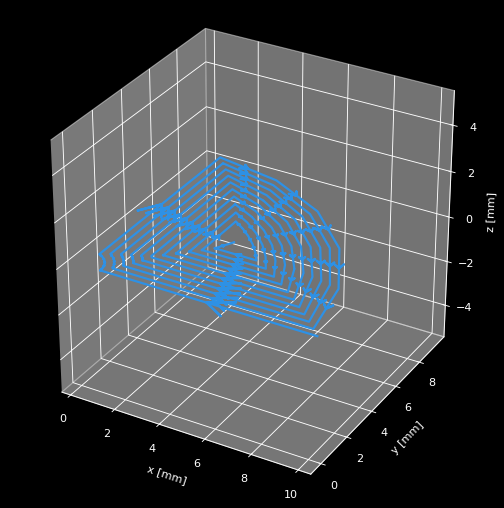

/usr/local/lib/python3.8/dist-packages/magpylib/_src/display/traces_utility.py:95: RuntimeWarning:

invalid value encountered in divide



In [3]:
trace = magpy.current.Line(current=1.0, vertices=list(pts))
trace.show()


fig = go.Figure()
magpy.show(trace,canvas=fig,backend='plotly')
fig.write_html('temp.html')


In [4]:
# create grid
#ts = np.linspace(-20, 20, 20)
npts = 100
ts = np.linspace(-10, 10, npts)
xs  = np.linspace(-10, 10, npts)
zs = np.linspace(-10, 10, npts)
grid = np.array([[(x,0,z) for x in ts] for z in ts])
gridTop = np.array([[(x,y,0) for x in ts] for y in ts])

print(f"Grid element count: {len(grid.flatten()):,}")



Grid element count: 30,000


In [5]:
# compute and plot side-view field of trace
B = magpy.getB(trace, grid)
Bamp = np.linalg.norm(B, axis=2)
Bamp /= np.amax(Bamp)

In [6]:
# compute and plot top-view field of trace
B2 = magpy.getB(trace, gridTop)
Bamp2 = np.linalg.norm(B2, axis=2)
Bamp2 /= np.amax(Bamp2)

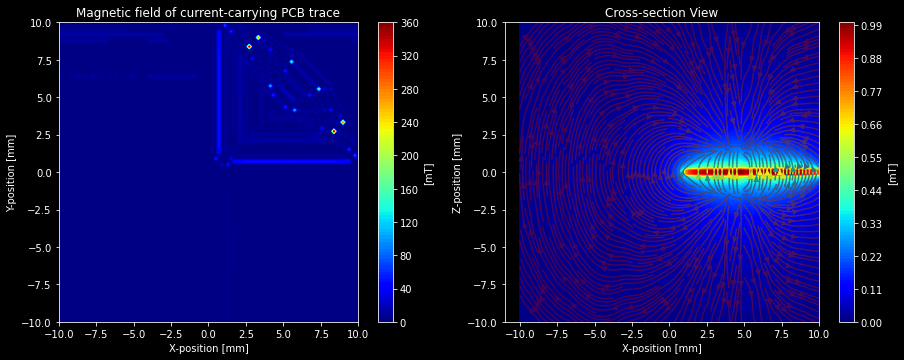

In [7]:
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(13, 5))

# Side view
cp = ax2.contourf(
    grid[:,:,0], grid[:,:,2], Bamp,
    levels=100,
    cmap='jet',
)

X,Y = np.meshgrid(xs,zs)
U,V = B2[:,:,0], B2[:,:,2]
amp = np.sqrt(U**2+V**2)
# Top view
sp = ax1.contourf(
    X, Y, amp,
    np.linspace(-100,100,100),
    levels=100,
    cmap='jet',
)

ax2.streamplot(
    grid[:,:,0], grid[:,:,2], B[:,:,0], B[:,:,2],
    density=3,
    color=Bamp,
)

# figure styling
ax1.set(
    title='Magnetic field of current-carrying PCB trace',
    xlabel='X-position [mm]',
    ylabel='Y-position [mm]',
    aspect=1,
)
ax2.set(
    title='Cross-section View',
    xlabel='X-position [mm]',
    ylabel='Z-position [mm]',
    aspect=1,
)

plt.colorbar(sp, ax=ax1, label='[mT]')
plt.colorbar(cp, ax=ax2, label='[mT]')

plt.tight_layout()
plt.show()
# plt.savefig('magplotlib_example.png')

In [43]:
# Range of points in to evaluate in each direction.
ndim = 3
npts = 20
x = np.linspace(-5,15,npts+11)
y = np.linspace(-5,15,npts+11)
z = np.linspace(-5,5,npts)
mesh = np.meshgrid(x,y,z)
points = np.array(mesh).T.reshape(-1,ndim)

# Get the vector field at each point.
Bvect = magpy.getB(trace,points)

In [64]:
# Create a cone plot.
fig = go.Figure()
magpy.show(trace,canvas=fig,backend='plotly')
trc = go.Cone(x=points[:,0],y=points[:,1],z=points[:,2],
              u=Bvect[:,0],v=Bvect[:,1],w=Bvect[:,2],
              colorscale='Blues',
              sizemode='absolute',
              opacity=0.5,
              sizeref=3)
fig.add_trace(trc)

idx = np.arange(0,len(points),int(len(points)/100))
trc = go.Streamtube(x=points[:,0],y=points[:,1],z=points[:,2],
              u=Bvect[:,0],v=Bvect[:,1],w=Bvect[:,2],
              showscale=False,
              colorscale='Blues',
              maxdisplayed=1000,
              sizeref=0.2,
              starts = dict(x=points[idx,0],y=points[idx,1],z=points[idx,2]*0))
fig.add_trace(trc)

fig.write_html('b-field.html')

In [54]:
len(points)

19220